In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import  matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
# Now train the DT classifier
# Load libraries
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb

In [4]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
print('done')

done


In [5]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
new_labels = labels.replace("unknown", 3)

In [6]:
@torch.no_grad()
def test(model, data, loss_fn):
    model.eval()
    res = {}
    losses = []
    for i, batch in enumerate(data):
        out = model.forward(batch)
        y_true = batch.y
        indexes = y_true != 2

        y_pred = out.argmax(dim=-1, keepdim=True)[indexes].view(-1, 1).cpu().detach().numpy()
        y_true = y_true[indexes].view(-1, 1).cpu().detach().numpy()

        res = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    return res

In [7]:
def trainGCN(data):
    GCN = GNN_Example(node_dim=data['train'][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3,
                      K=2, dropout_rate=0.1).to(device)

    lr = 1e-3
    epochs = 50
    # weights for classes
    weight = torch.tensor([0.5, 0.5]).to(device)
    optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
    loss_fn = torch.nn.NLLLoss(weight)

    best_test_loss = 10e9
    best_result = None
    train_losses = []
    test_losses = []
    result = None
    for epoch in range(1, 1 + epochs):
        # train with random split
        loss = train(GCN, data['train'], optimizer, loss_fn, device)
        train_losses.append(loss)
        result = test(GCN, data["test"],loss_fn)

        # if epoch % 10 == 0:
        #     print("Epoch: ", epoch)
        #     for item, amount in result.items():
        #         print("{} ({})".format(item, amount))
        #     print("############################")

    return result


In [13]:
# cross validation
results = []
f1_scores = []
avg_score = []
for idx in range(1):
    print("Starting Index: ", idx)
    # data, graph_info = time_step_split_cross_validation(nodes, edges, new_labels, device, test_index=idx)
    data, graph_info = time_step_split(nodes, edges, new_labels, device, train_lt = 31, val_lt = 36, test_lt = 49)

    train_emb = []
    train_y   = []
    for i in range(len(data['train'])):
        indexes= (data["train"][i].y != 2)
        train_emb.append(data['train'][i].x[indexes])
        train_y.append(data['train'][i].y[indexes])

    train_emb = torch.cat(train_emb)
    train_y   = torch.cat(train_y)

    test_emb = []
    test_y   = []
    for i in range(len(data['test'])):
        indexes= (data['test'][i].y != 2)
        test_emb.append(data['test'][i].x[indexes])
        test_y.append(data['test'][i].y[indexes])

    test_emb = torch.cat(test_emb)
    test_y   = torch.cat(test_y)

    # Create Decision Tree classifer object
    clf = RandomForestClassifier()
    # Train Decision Tree Classifer
    clf = clf.fit(train_emb, train_y)
    #Predict the response for test dataset
    y_pred = clf.predict(test_emb)
    f1_scored = f1_score(test_y, y_pred, average=None)
    print(f1_scored)
    avg_score.append((f1_score(test_y, y_pred, average='macro')))
    f1_scores.append(f1_scored)
    print("Done")

Starting Index:  0
[0.77739959 0.9873123 ]
Done


In [9]:
# mean and std for average
print(np.mean(np.array(avg_score)))
print(np.std(np.array(avg_score)))

0.891008372256338
0.14539994092483255


In [24]:
# mean and std for class 0
print(np.mean(np.array(f1_scores)[:,0]))
print(np.std(np.array(f1_scores)[:,0]))

# mean and std for class 1
print(np.mean(np.array(f1_scores)[:,1]))
print(np.std(np.array(f1_scores)[:,1]))

0.9939669106062284
0.005576815883049175
0.8009368304691742
0.26484426301472397
0.9939669106062284
0.005576815883049175


In [9]:
with open("results_cross_validation", "rb") as fp:   # Unpickling
    cv = pickle.load(fp)
print(cv)

[(0, {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '1': {'precision': 0.9920560747663552, 'recall': 0.9967136150234742, 'f1-score': 0.9943793911007026, 'support': 2130}, 'accuracy': 0.9888216115510013, 'macro avg': {'precision': 0.4960280373831776, 'recall': 0.4983568075117371, 'f1-score': 0.4971896955503513, 'support': 2147}, 'weighted avg': {'precision': 0.9842009498147819, 'recall': 0.9888216115510013, 'f1-score': 0.9865058700719593, 'support': 2147}}), (1, {'0': {'precision': 0.16666666666666666, 'recall': 0.05555555555555555, 'f1-score': 0.08333333333333333, 'support': 18}, '1': {'precision': 0.9846984698469847, 'recall': 0.9954504094631483, 'f1-score': 0.9900452488687784, 'support': 1099}, 'accuracy': 0.9803043867502238, 'macro avg': {'precision': 0.5756825682568257, 'recall': 0.5255029825093519, 'f1-score': 0.5366892911010559, 'support': 1117}, 'weighted avg': {'precision': 0.971516220556702, 'recall': 0.9803043867502238, 'f1-score': 0.9754339556909467

In [24]:
print(cv[0][0])
print(cv[0][1])
print(cv[0])

0
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '1': {'precision': 0.9920560747663552, 'recall': 0.9967136150234742, 'f1-score': 0.9943793911007026, 'support': 2130}, 'accuracy': 0.9888216115510013, 'macro avg': {'precision': 0.4960280373831776, 'recall': 0.4983568075117371, 'f1-score': 0.4971896955503513, 'support': 2147}, 'weighted avg': {'precision': 0.9842009498147819, 'recall': 0.9888216115510013, 'f1-score': 0.9865058700719593, 'support': 2147}}
(0, {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '1': {'precision': 0.9920560747663552, 'recall': 0.9967136150234742, 'f1-score': 0.9943793911007026, 'support': 2130}, 'accuracy': 0.9888216115510013, 'macro avg': {'precision': 0.4960280373831776, 'recall': 0.4983568075117371, 'f1-score': 0.4971896955503513, 'support': 2147}, 'weighted avg': {'precision': 0.9842009498147819, 'recall': 0.9888216115510013, 'f1-score': 0.9865058700719593, 'support': 2147}})


In [42]:
# for each time step plot f1 score for each class
# f1-score
illicit_f1_scores = []
licit_f1_scores   = []

for timestep in range(len(cv)):
    illicit_f1_scores.append(cv[timestep][1]['0']['f1-score'])
    licit_f1_scores.append(cv[timestep][1]['1']['f1-score'])


Text(0, 0.5, 'F1-Score Illicit class')

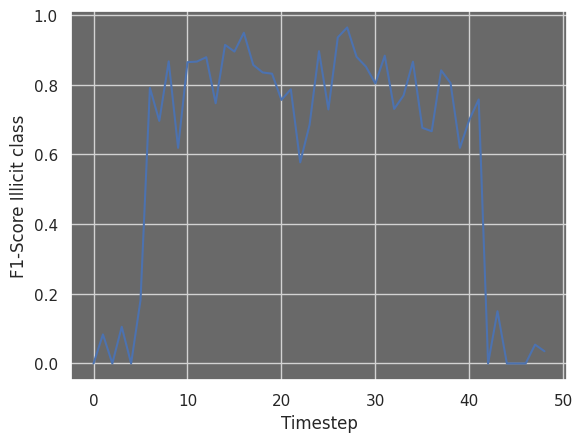

In [43]:
plt.plot(illicit_f1_scores)
plt.xlabel('Timestep')
plt.ylabel('F1-Score Illicit class')

(0.0, 1.1)

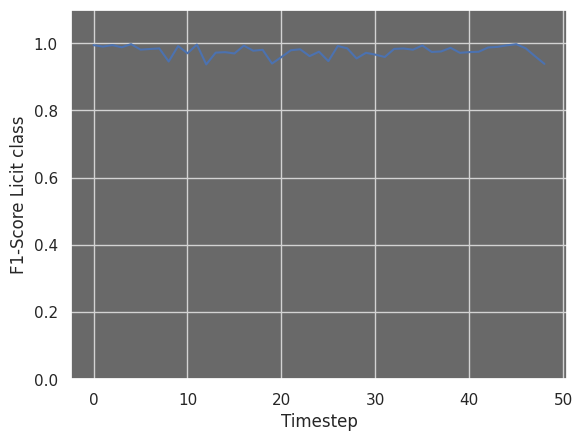

In [46]:
plt.plot(licit_f1_scores)
plt.xlabel('Timestep')
plt.ylabel('F1-Score Licit class')
plt.ylim(0,1.1)